## Auxillary functions and imports

In [1]:
import sys
sys.path.append("/home/mikhail/Spiking-NASLib/")


import naslib
naslib.search_spaces.NasBenchSpikingASRSearchSpace

importing search_spaces


naslib.search_spaces.nasbenchspikingasr.graph.NasBenchSpikingASRSearchSpace

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import torch
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns


import sys
sys.path.append("..")
import os
import logging

import naslib
# from naslib.optimizers import DARTSOptimizer
# from naslib.search_spaces import NasBenchSpikingASRSearchSpace #NasBenchASRSearchSpace #NasBench301SearchSpace#NasBenchNLPSearchSpace
# from naslib.utils import set_seed, setup_logger, get_config_from_args, create_exp_dir

# from naslib import utils
# from naslib.defaults.trainer import Trainer
from torch.utils.tensorboard import SummaryWriter
import torch


def get_edge_info(optimizer, arch_weights, config):
    edge_info = {}
    min_soft, max_soft = np.inf, -np.inf

    alpha_idx = 0
    for graph in optimizer.graph._get_child_graphs(single_instances=True):
        for u, v, edge_data in graph.edges.data():
            if edge_data.has("alpha"):
                edge_weights = arch_weights[alpha_idx]

                steps, num_alphas = edge_weights.shape
                steps_per_epoch = steps // config.search.epochs

                disc_weights = torch.mean(edge_weights.detach().reshape(-1, steps_per_epoch, num_alphas), axis=1).cpu()    
                soft_weights = torch.softmax(disc_weights, dim=-1).numpy()
                
                cell_name = edge_data['cell_name'] if hasattr(edge_data, 'cell_name') else ""
                edge_info[(u, v, cell_name)] = {}
                edge_info[(u, v, cell_name)]['op_names'] = [op.get_op_name for op in edge_data.op.get_embedded_ops()]
                edge_info[(u, v, cell_name)]['alphas'] = soft_weights

                min_soft = min(min_soft, np.min(soft_weights))
                max_soft = max(max_soft, np.max(soft_weights))

                alpha_idx += 1

    return edge_info, min_soft, max_soft


def plot_architectural_weights(config, optimizer, max_rows=4):
    arch_weights = [torch.load(f'{config.save}/arch_weights.pt')] # load alphas

    # get dictionary of 
    edge_info, min_soft, max_soft = get_edge_info(optimizer, arch_weights, config)

    for start_id in range(0, len(edge_info.keys()), max_rows):
        
        # calculate number of rows in plot
        n_rows = min(max_rows, len(edge_info.keys())-start_id)
        logger.info(f"Creating plot {config.save}/arch_weights_{start_id+1}to{start_id+n_rows}.png")

        # define figure and axes and NASLib colormap
        fig, axes = plt.subplots(nrows=n_rows, figsize=(10, max_rows))
        cmap = sns.diverging_palette(230, 0, 90, 60, as_cmap=True)

        # iterate over arch weights and create heatmaps
        for ax_id, (u, v, cell_name) in enumerate(list(edge_info.keys())[start_id:start_id+n_rows]): 
            map = sns.heatmap(
                edge_info[(u, v, cell_name)]['alphas'].T,
                cmap=cmap, 
                vmin=min_soft,
                vmax=max_soft, 
                ax=axes[ax_id],
                cbar=True
            )

            op_names = edge_info[(u, v, cell_name)]['op_names']

            if ax_id < n_rows-1:        
                axes[ax_id].set_xticks([])
            axes[ax_id].set_ylabel(f"{u, v}", fontdict=dict(fontsize=6))
            axes[ax_id].set_yticks(np.arange(len(op_names)) + 0.5)
            fontsize = max(6, 40/len(op_names))
            axes[ax_id].set_yticklabels(op_names, rotation=360, fontdict=dict(fontsize=fontsize))
            if cell_name != "":
                axes[ax_id].set_title(cell_name, fontdict=dict(fontsize=6))
            cbar = map.collections[0].colorbar
            cbar.ax.tick_params(labelsize=6)
            cbar.ax.set_title('softmax', fontdict=dict(fontsize=6))

        axes[ax_id].xaxis.set_tick_params(labelsize=6)
        axes[ax_id].set_xlabel("Epoch", fontdict=dict(fontsize=6))

        fig.suptitle(f"optimizer: {config.optimizer}, search space: {config.search_space}, dataset: {config.dataset}, seed: {config.seed}")
        fig.tight_layout()
        fig.savefig(f"{config.save}/arch_weights_{start_id+1}to{start_id+n_rows}.png", dpi=300)



## Neural architecture search

[05/06 21:57:29 nl.defaults.trainer]: Beginning search
batch_size 16
Available at: /home/mikhail/data/audiospikes/shd_train.h5
Available at: /home/mikhail/data/audiospikes/shd_test.h5
Input shape:  (16312, 100, 350) Output shape:  (16312,) Number of samples:  16312
Input shape:  (4528, 100, 350) Output shape:  (4528,) Number of samples:  4528
starting training, epochs:


  0%|                                                                      | 0/3 [00:00<?, ?it/s]

[05/06 21:57:38 nl.optimizers.oneshot.darts.optimizer]: Arch weights (alphas, last column argmax): 
-0.001058, +0.000593, 1
+0.000809, -0.001888, 0
+0.000858, +0.001197, 1
+0.000239, +0.000327, -0.001333, -0.001799, +0.000084, -0.001355, 1
+0.001409, +0.000013, 0
-0.000658, -0.001422, 0
+0.000175, -0.001056, -0.000257, +0.001277, +0.000467, -0.000251, 3
-0.001491, +0.000291, 1
+0.000602, -0.001639, +0.001132, +0.000752, -0.000729, +0.001926, 5



  0%|                                                                      | 0/5 [00:00<?, ?it/s]

[05/06 21:57:39 nl.defaults.trainer]: Epoch 0-0, Train loss: 2.99349, validation loss: 2.99602, learning rate: [0.025]
[05/06 21:57:39 nl.defaults.trainer]: cuda consumption
 |===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|--------------------------------------------


 20%|████████████▍                                                 | 1/5 [00:01<00:06,  1.51s/it]

[05/06 21:57:41 nl.defaults.trainer]: cuda consumption
 |===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       


 40%|████████████████████████▊                                     | 2/5 [00:02<00:04,  1.37s/it]

[05/06 21:57:42 nl.defaults.trainer]: cuda consumption
 |===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       


 80%|█████████████████████████████████████████████████▌            | 4/5 [00:05<00:01,  1.38s/it]

[05/06 21:57:45 nl.defaults.trainer]: Epoch 0-4, Train loss: 2.98505, validation loss: 2.99060, learning rate: [0.025]



100%|██████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.37s/it]

[05/06 21:57:45 nl.optimizers.oneshot.darts.optimizer]: Arch weights before discretization: [Parameter containing:
tensor([ 0.0029, -0.0032], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.1297, -0.1307], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.0632,  0.0643], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.0533, -0.1024,  0.0866, -0.0287, -0.0615, -0.1540], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([ 0.0575, -0.0563], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0192, -0.0210], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.1255, -0.0626,  0.0947, -0.0122, -0.0618, -0.0558], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([ 0.0136, -0.0146], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0378, -0.0328, -0.0100, -0.0043, -0.0432, -0.0055], device='cuda:1',
       requires_grad=Tr

anytime_results 2.989964485168457 <class 'float'>
[05/06 21:57:45 nl.defaults.trainer]: Epoch 0, Anytime results: 2.989964485168457
[05/06 21:57:45 nl.defaults.trainer]: Epoch 0 done. Train accuracy: 2.85714, Validation accuracy: 1.25000


 33%|████████████████████▋                                         | 1/3 [00:07<00:14,  7.11s/it]

[05/06 21:57:45 nl.optimizers.oneshot.darts.optimizer]: Arch weights (alphas, last column argmax): 
+0.002889, -0.003201, 0
+0.129747, -0.130710, 0
-0.063162, +0.064252, 1
-0.053322, -0.102445, +0.086584, -0.028707, -0.061503, -0.154019, 2
+0.057457, -0.056319, 0
+0.019202, -0.020985, 0
-0.125524, -0.062646, +0.094724, -0.012225, -0.061820, -0.055841, 2
+0.013554, -0.014561, 0
+0.037846, -0.032838, -0.009984, -0.004307, -0.043201, -0.005461, 0



 60%|█████████████████████████████████████▏                        | 3/5 [00:03<00:02,  1.28s/it]

[05/06 21:57:50 nl.defaults.trainer]: Epoch 1-3, Train loss: 2.93578, validation loss: 3.01070, learning rate: [0.019000000000000003]



100%|██████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]

[05/06 21:57:51 nl.optimizers.oneshot.darts.optimizer]: Arch weights before discretization: [Parameter containing:
tensor([ 0.0849, -0.0851], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.2269, -0.2277], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0118, -0.0113], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.0452, -0.1024,  0.0973, -0.0712, -0.0529, -0.1420], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([ 0.1154, -0.1146], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0036, -0.0050], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.0591, -0.0926,  0.0867, -0.0612, -0.1029,  0.0208], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([-0.0262,  0.0254], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0476, -0.0298, -0.0003, -0.0499, -0.0568,  0.0088], device='cuda:1',
       requires_grad=Tr

anytime_results 3.018465518951416 <class 'float'>
[05/06 21:57:52 nl.defaults.trainer]: Epoch 1, Anytime results: 3.018465518951416
[05/06 21:57:52 nl.defaults.trainer]: Epoch 1 done. Train accuracy: 14.28571, Validation accuracy: 6.25000


 67%|█████████████████████████████████████████▎                    | 2/3 [00:13<00:06,  6.94s/it]

[05/06 21:57:52 nl.optimizers.oneshot.darts.optimizer]: Arch weights (alphas, last column argmax): 
+0.084897, -0.085087, 0
+0.226946, -0.227716, 0
+0.011848, -0.011313, 0
-0.045213, -0.102448, +0.097253, -0.071199, -0.052939, -0.142049, 2
+0.115425, -0.114598, 0
+0.003623, -0.005015, 0
-0.059109, -0.092631, +0.086651, -0.061170, -0.102922, +0.020777, 2
-0.026175, +0.025429, 1
+0.047596, -0.029799, -0.000304, -0.049922, -0.056765, +0.008777, 0



 40%|████████████████████████▊                                     | 2/5 [00:02<00:03,  1.28s/it]

[05/06 21:57:56 nl.defaults.trainer]: Epoch 2-2, Train loss: 2.93422, validation loss: 3.02291, learning rate: [0.007000000000000004]



100%|██████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]

[05/06 21:57:58 nl.optimizers.oneshot.darts.optimizer]: Arch weights before discretization: [Parameter containing:
tensor([ 0.0208, -0.0208], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.2166, -0.2170], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.1110,  0.1113], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.1234, -0.0150,  0.1358, -0.0748,  0.0109, -0.0428], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([ 0.2041, -0.2035], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0342, -0.0353], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.1160, -0.0993,  0.1696, -0.0675, -0.1325,  0.1685], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([ 0.0794, -0.0800], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.1611, -0.1187, -0.0793, -0.1601, -0.1553, -0.0191], device='cuda:1',
       requires_grad=Tr

anytime_results 2.9871010780334473 <class 'float'>
[05/06 21:57:59 nl.defaults.trainer]: Epoch 2, Anytime results: 2.9871010780334473
[05/06 21:57:59 nl.defaults.trainer]: Epoch 2 done. Train accuracy: 12.85714, Validation accuracy: 7.50000


100%|██████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.93s/it]

[05/06 21:57:59 nl.defaults.trainer]: Saving architectural weight tensors: run/darts/shd/re/0/arch_weights.pt
[05/06 21:57:59 nl.utils.vis]: Creating plot run/darts/shd/re/0/arch_weights_1to4.png


[05/06 21:57:59 nl.utils.vis]: Creating plot run/darts/shd/re/0/arch_weights_5to8.png
[05/06 21:58:00 nl.utils.vis]: Creating plot run/darts/shd/re/0/arch_weights_9to9.png
[05/06 21:58:00 nl.defaults.trainer]: Training finished


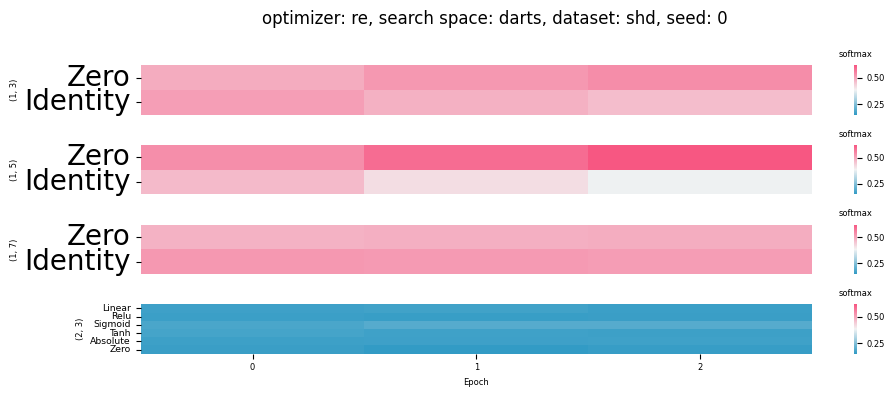

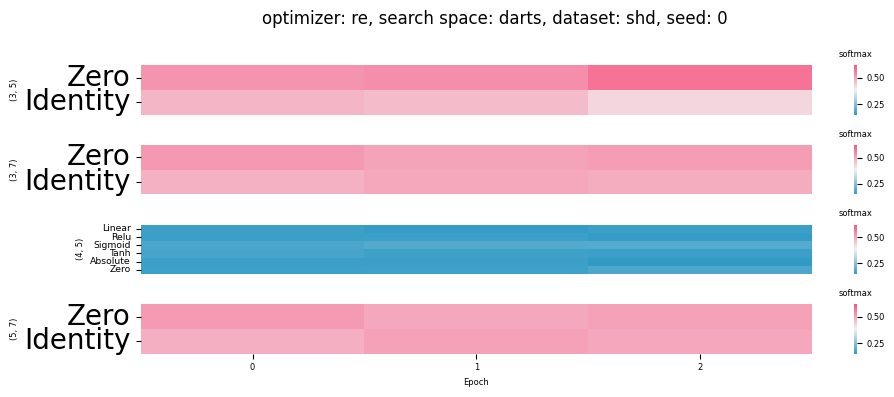

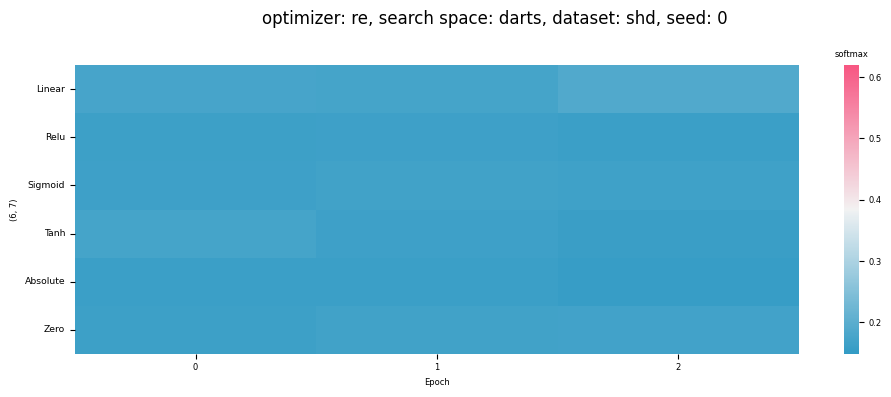

In [3]:
search_space = naslib.search_spaces.NasBenchSpikingASRSearchSpace()  #NasBenchNLPSearchSpace()

config = naslib.utils.get_config_from_args()
config.save_arch_weights = True
config.plot_arch_weights = True
config.save = "{}/{}/{}/{}/{}".format(
    config.out_dir, config.search_space, config.dataset, config.optimizer, config.seed
)
naslib.utils.create_exp_dir(config.save)
naslib.utils.create_exp_dir(config.save + "/search")  # required for the checkpoints
naslib.utils.create_exp_dir(config.save + "/eval")

logger = naslib.utils.setup_logger(config.save + "/log.log")
logger.setLevel(logging.INFO)  # default DEBUG is very verbose


optimizer = naslib.optimizers.DARTSOptimizer(config)
optimizer.adapt_search_space(search_space)  
optimizer.before_training() # loads the graph to the gpu


trainer = naslib.defaults.trainer.Trainer(optimizer, config)
# trainer.search(summary_writer=SummaryWriter("runs/shd"))
with torch.autograd.set_detect_anomaly(True):
    trainer.search(summary_writer=SummaryWriter("runs/shd"))
# trainer.evaluate()




In [4]:
# import importlib
# import naslib
# importlib.reload(naslib)

best_model = optimizer.get_final_architecture()

trainer.evaluate(best_arch=best_model, retrain=False)

[05/06 21:58:01 nl.optimizers.oneshot.darts.optimizer]: Arch weights before discretization: [Parameter containing:
tensor([ 0.0208, -0.0208], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.2166, -0.2170], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.1110,  0.1113], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.1234, -0.0150,  0.1358, -0.0748,  0.0109, -0.0428], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([ 0.2041, -0.2035], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0342, -0.0353], device='cuda:1', requires_grad=True), Parameter containing:
tensor([-0.1160, -0.0993,  0.1696, -0.0675, -0.1325,  0.1685], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([ 0.0794, -0.0800], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.1611, -0.1187, -0.0793, -0.1601, -0.1553, -0.0191], device='cuda:1',
       requires_grad=Tr

AttributeError: 'Trainer' object has no attribute 'test_queue'

## Getting the graph of a continuous model

In [ ]:

logger = logging.getLogger(__name__)

arch_weights = torch.load(f'{config.save}/arch_weights.pt')

edge_info, min_soft, max_soft = get_edge_info(optimizer, arch_weights, config)
edge_info#.keys()

edge_info[(1, 2, '')] = {'op_names': ['Identity'],
  'alphas': np.array([[1],
         [1],
         [1]], dtype=np.float32)}
edge_info[(3, 4, '')] = {'op_names': ['Identity'],
  'alphas': np.array([[1],
         [1],
         [1]], dtype=np.float32)}
edge_info[(5, 6, '')] = {'op_names': ['Identity'],
  'alphas': np.array([[1],
         [1],
         [1]], dtype=np.float32)}


G = nx.DiGraph()

# Add nodes and edges
for (start, end, _), edge_data in edge_info.items():
    G.add_edge(start, end, **edge_data)

# Plot the graph# Plot the graph
pos = {node: (2 * (node % 2),  -1 * node) for node in G.nodes()}  # Arrange nodes in layers
# print(pos)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=20, font_weight="bold")

def get_op_name(op):
    if callable(op):
        op = op()
    match = re.search(r"(\w+)'", str(op))
    return match.group(1) if match else str(op)

edge_labels = {
    (start, end): f"{', '.join([get_op_name(op_name) for op_name in edge_data['op_names']])}\n{', '.join([f'{alpha:.2f}' for alpha in edge_data['alphas'][-1]])}"
    for (start, end, _), edge_data in edge_info.items()
}
# edge_labels = {
#     (start, end): f"{', '.join([get_op_name(op_name) for op_name in edge_data['op_names']])}"
#     for (start, end, _), edge_data in edge_info.items()
# }
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, rotate=False)

plt.show()

## Getting the graph of a discrete model

In [ ]:
# discretization
best_model = optimizer.get_final_architecture()

edge_info = {}
for graph in best_model._get_child_graphs(single_instances=True):
    for u, v, edge_data in graph.edges.data():
        if edge_data.has("alpha"):
            cell_name = edge_data['cell_name'] if hasattr(edge_data, 'cell_name') else ""
            edge_info[(u, v, cell_name)] = {}
            edge_info[(u, v, cell_name)]['op_names'] = [edge_data.op.get_op_name]
            
edge_info[(1, 2, '')] = {'op_names': ['Identity'],
  'alphas': np.array([[1],
         [1],
         [1]], dtype=np.float32)}
edge_info[(3, 4, '')] = {'op_names': ['Identity'],
  'alphas': np.array([[1],
         [1],
         [1]], dtype=np.float32)}
edge_info[(5, 6, '')] = {'op_names': ['Identity'],
  'alphas': np.array([[1],
         [1],
         [1]], dtype=np.float32)}

import networkx as nx
import matplotlib.pyplot as plt
import re


G = nx.DiGraph()

# Add nodes and edges
for (start, end, _), edge_data in edge_info.items():
    G.add_edge(start, end, **edge_data)

# Plot the graph# Plot the graph
pos = {node: (2 * (node % 2),  -1 * node) for node in G.nodes()}  # Arrange nodes in layers
# print(pos)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=20, font_weight="bold")

def get_op_name(op):
    if callable(op):
        op = op()
    match = re.search(r"(\w+)'", str(op))
    return match.group(1) if match else str(op)


edge_labels = {
    (start, end): f"{', '.join([get_op_name(op_name) for op_name in edge_data['op_names']])}"
    for (start, end, _), edge_data in edge_info.items()
}


nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, rotate=False)

plt.show()

In [ ]:
best_model

In [ ]:
res = optimizer.test_statistics()
print(res)

In [ ]:
import numpy as np

arch_weights = torch.load(f'{config.save}/arch_weights.pt')
max_rows = 4
for start_id in range(0, len(edge_info.keys()), max_rows):
        
    # calculate number of rows in plot
    n_rows = min(max_rows, len(edge_info.keys())-start_id)
    logger.info(f"Creating plot {config.save}/arch_weights_{start_id+1}to{start_id+n_rows}.png")

    # define figure and axes and NASLib colormap
    fig, axes = plt.subplots(nrows=n_rows, figsize=(10, max_rows))
    cmap = sns.diverging_palette(230, 0, 90, 60, as_cmap=True)

    # When there's only one row, axes will be an 'Axes' object and not an array
    # We convert it into a 1-element list in that case
    if n_rows == 1:
        axes = [axes]

    for ax_id, (u, v, cell_name) in enumerate(list(edge_info.keys())[start_id:start_id+n_rows]):
        ax = axes[ax_id]

        map = sns.heatmap(
            edge_info[(u, v, cell_name)]['alphas'].T,
            cmap=cmap,
            vmin=min_soft,
            vmax=max_soft,
            ax=ax,  # Use the correct axes
            cbar=True
        )
        op_names = edge_info[(u, v, cell_name)]['op_names']
        op_names = [get_op_name(op_name) for op_name in op_names]
        if ax_id < n_rows-1:        
            axes[ax_id].set_xticks([])
        axes[ax_id].set_ylabel(f"{u, v}", fontdict=dict(fontsize=6))
        axes[ax_id].set_yticks(np.arange(len(op_names)) + 0.5)
        fontsize = max(6, 40/len(op_names))
        axes[ax_id].set_yticklabels(op_names, rotation=360, fontdict=dict(fontsize=fontsize))
        if cell_name != "":
                axes[ax_id].set_title(cell_name, fontdict=dict(fontsize=6))
        cbar = map.collections[0].colorbar
        cbar.ax.tick_params(labelsize=6)
        cbar.ax.set_title('softmax', fontdict=dict(fontsize=6))

    axes[ax_id].xaxis.set_tick_params(labelsize=6)
    axes[ax_id].set_xlabel("Epoch", fontdict=dict(fontsize=6))

    fig.suptitle(f"optimizer: {config.optimizer}, search space: {config.search_space}, dataset: {config.dataset}, seed: {config.seed}")
    fig.tight_layout()
    fig.savefig(f"{config.save}/arch_weights_{start_id+1}to{start_id+n_rows}.png", dpi=300)

# plot_architectural_weights(config, optimizer)


In [ ]:
arch_weights = torch.load(f'{config.save}/arch_weights.pt')
max_rows = 4
for start_id in range(0, len(edge_info.keys()), max_rows):
        
        # calculate number of rows in plot
        n_rows = min(max_rows, len(edge_info.keys())-start_id)
        logger.info(f"Creating plot {config.save}/arch_weights_{start_id+1}to{start_id+n_rows}.png")

        # define figure and axes and NASLib colormap
        fig, axes = plt.subplots(nrows=n_rows, figsize=(10, max_rows))
        cmap = sns.diverging_palette(230, 0, 90, 60, as_cmap=True)

        # iterate over arch weights and create heatmaps
        is_2d_axes = np.ndim(axes) == 2

        # Your loop starts here
        for ax_id, (u, v, cell_name) in enumerate(list(edge_info.keys())[start_id:start_id+n_rows]):
            # Get the correct axes based on the dimensions
            ax = axes[ax_id] if not is_2d_axes else axes[ax_id // ncols, ax_id % ncols]

            map = sns.heatmap(
                edge_info[(u, v, cell_name)]['alphas'].T,
                cmap=cmap,
                vmin=min_soft,
                vmax=max_soft,
                ax=ax,  # Use the correct axes
                cbar=True
            )
            op_names = edge_info[(u, v, cell_name)]['op_names']

            if ax_id < n_rows-1:        
                axes[ax_id].set_xticks([])
            axes[ax_id].set_ylabel(f"{u, v}", fontdict=dict(fontsize=6))
            axes[ax_id].set_yticks(np.arange(len(op_names)) + 0.5)
            fontsize = max(6, 40/len(op_names))
            axes[ax_id].set_yticklabels(op_names, rotation=360, fontdict=dict(fontsize=fontsize))
            if cell_name != "":
                axes[ax_id].set_title(cell_name, fontdict=dict(fontsize=6))
            cbar = map.collections[0].colorbar
            cbar.ax.tick_params(labelsize=6)
            cbar.ax.set_title('softmax', fontdict=dict(fontsize=6))

        axes[ax_id].xaxis.set_tick_params(labelsize=6)
        axes[ax_id].set_xlabel("Epoch", fontdict=dict(fontsize=6))

        fig.suptitle(f"optimizer: {config.optimizer}, search space: {config.search_space}, dataset: {config.dataset}, seed: {config.seed}")
        fig.tight_layout()
        fig.savefig(f"{config.save}/arch_weights_{start_id+1}to{start_id+n_rows}.png", dpi=300)

plot_architectural_weights(config, optimizer)

In [ ]:
import pickle
pickle.dump(trainer, open("trainer.pkl", "wb"))
pickle.dump(optimizer, open("optimizer.pkl", "wb"))


In [ ]:
trainer = pickle.load(open("trainer.pkl", "rb"))
optimizer = pickle.load(open("optimizer.pkl", "rb"))

In [ ]:
arch_weights

In [ ]:
print(arch_weights.keys())

print(type(arch_weights['model']), arch_weights['model'].keys(), type(arch_weights['iteration']))

In [ ]:
trainer.evaluate_oneshot()

In [ ]:
trainer.evaluate()

In [ ]:
import sys

sys.path.append("..")
# if you encounter ModuleNotFoundError: No module named 'naslib'
# then you need to add the naslib directory to your PYTHONPATH
# export PYTHONPATH=$PYTHONPATH:/path/to/naslib or export PYTHONPATH=$PYTHONPATH:$pwd

from naslib.optimizers import DARTSOptimizer
from naslib.search_spaces import NasBenchASRSearchSpace #NasBench301SearchSpace#NasBenchNLPSearchSpace

from naslib import utils
from naslib.defaults.trainer import Trainer
from torch.utils.tensorboard import SummaryWriter
import torch


search_space = NasBenchASRSearchSpace()  #NasBenchNLPSearchSpace()
config = utils.get_config_from_args()
optimizer = DARTSOptimizer(config)
optimizer.adapt_search_space(search_space)  
optimizer.before_training() # loads the graph to the gpu


trainer = Trainer(optimizer, config)
# trainer.search(summary_writer=SummaryWriter("runs/shd"))
with torch.autograd.set_detect_anomaly(True):
    trainer.search(summary_writer=SummaryWriter("runs/shd"))
trainer.evaluate()


# import argparse
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from torch.utils.data import DataLoader
# from torch.utils.data import ConcatDataset
# from spiking_data import get_numpy_datasets
# train_datasets, test_datasets = get_numpy_datasets("shd", n_inp=100)
# train_dataset = ConcatDataset(train_datasets)
# test_dataset = ConcatDataset(test_datasets)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# search_space.to(device)

# config = utils.AttrDict()
# config.dataset = 'shd'
# config.resume = False
# config.search = utils.AttrDict()
# config.search.grad_clip = None
# config.search.checkpoint_freq = 10
# config.search.learning_rate = 0.01
# config.search.momentum = 0.1
# config.search.weight_decay = 0.1
# config.search.arch_learning_rate = 0.01
# config.search.arch_weight_decay = 0.1
# config.search.tau_max = 10
# config.search.tau_min = 1
# config.search.epochs = 2
# config.search.seed = 42

# epochs = 50
# lr = 0.025
# momentum = 0.9
# weight_decay = 3e-4

# architect = DARTSOptimizer(config)
# optimizer = optim.SGD(search_space.parameters(), lr, momentum=momentum, weight_decay=weight_decay)
# scheduler = CosineAnnealingLR(optimizer, epochs)

# for epoch in range(1, epochs + 1):
#     train_loss = train(train_loader, optimizer, device)
#     valid_acc = test(test_loader, search_space, device)
#     scheduler.step()
#     print(f"Epoch {epoch}: Loss = {train_loss:.4f}, Validation accuracy = {valid_acc:.4f}")
